In [2]:

from diffusion_policy.dataset.real_pusht_image_dataset import RealPushTImageDataset

/home/tlips/.conda/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_path = "/home/tlips/Code/diffusion_policy/data/demo_place-cb-val"
import os
os.path.exists(dataset_path)


True

In [4]:
n_latency_steps = 0
n_obs_steps = 1
n_action_steps = 8
horizon = 16

shape_meta = {
    "obs": {
        "camera_0": {
            "shape": [3, 240, 320],
            "type": "rgb"
        },
        "camera_1": {
            "shape": [3, 240, 320],
            "type": "rgb"
        },
        "robot_eef_pose_6d_rot": {
            "shape": [9],
            "type": "low_dim"
        },
        "gripper_width": {
            "shape": [1],
            "type": "low_dim"
        }
    },
    "action": {
        "shape": [10]
    }
}

from omegaconf import OmegaConf
shape_meta = OmegaConf.create(shape_meta)

dataset = RealPushTImageDataset(shape_meta=shape_meta, dataset_path=dataset_path, horizon=horizon, pad_before=n_obs_steps-1+n_latency_steps, pad_after=n_action_steps-1, n_obs_steps=n_obs_steps, n_latency_steps=n_latency_steps, use_cache=True, seed=42, val_ratio=0.1, max_train_episodes=None, delta_action=False)

Acquiring lock on cache.
Loading cached ReplayBuffer from Disk.
Loaded!
image_keys: ['camera_0', 'camera_1']


In [5]:
print(len(dataset))
dataset.replay_buffer

732


/
 ├── data
 │   ├── action (917, 10) float64
 │   ├── camera_0 (917, 240, 320, 3) uint8
 │   ├── camera_1 (917, 240, 320, 3) uint8
 │   ├── gripper_width (917, 1) float64
 │   └── robot_eef_pose_6d_rot (917, 9) float64
 └── meta
     └── episode_ends (7,) int64

In [6]:
val_dataset = dataset.get_validation_dataset()
print(len(dataset))
dataset.replay_buffer

image_keys: ['camera_0', 'camera_1']
732


/
 ├── data
 │   ├── action (917, 10) float64
 │   ├── camera_0 (917, 240, 320, 3) uint8
 │   ├── camera_1 (917, 240, 320, 3) uint8
 │   ├── gripper_width (917, 1) float64
 │   └── robot_eef_pose_6d_rot (917, 9) float64
 └── meta
     └── episode_ends (7,) int64

In [7]:
checkpoint_path = "/home/tlips/Code/diffusion_policy/data/outputs/2025.02.06/18.44.43_train_diffusion_unet_image_real_image/checkpoints/epoch=0550-train_loss=0.001.ckpt"
# checkpoint_path = "/home/tlips/Code/diffusion_policy/data/outputs/2025.02.05/11.20.03_train_diffusion_unet_image_real_image/checkpoints/epoch=0150-train_loss=0.013.ckpt"
# checkpoint_path = "/home/tlips/Code/diffusion_policy/data/outputs/2025.02.07/11.26.11_train_diffusion_unet_image_real_image/checkpoints/epoch=0150-train_loss=0.006.ckpt"
# checkpoint_path = "/home/tlips/Code/diffusion_policy/data/outputs/2025.02.07/17.26.35_train_diffusion_unet_image_real_image/checkpoints/epoch=0500-train_loss=0.001.ckpt"
# checkpoint_path = "/home/tlips/Code/diffusion_policy/data/outputs/2025.02.10/19.17.42_train_diffusion_unet_image_real_image/checkpoints/epoch=0200-train_loss=0.002.ckpt"
checkpoint_path = "/home/tlips/Code/diffusion_policy/data/outputs/2025.02.11/12.41.31_train_diffusion_unet_image_real_image/checkpoints/epoch=0350-train_loss=0.001.ckpt"
omaga_config_path ="/home/tlips/Code/diffusion_policy/diffusion_policy/config/train_diffusion_unet_real_3d_image_workspace.yaml"
import dill
import torch
import hydra
from diffusion_policy.workspace.base_workspace import BaseWorkspace
import numpy as np
payload = torch.load(open(checkpoint_path, 'rb'), pickle_module=dill)
cfg = payload['cfg']
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)



observation encoder lr =0.0002
obs_encoder params: 121


In [8]:
policy = workspace.model
device = "cuda:0"
policy.eval().to(device)

# set inference params
policy.num_inference_steps = 16 # DDIM inference iterations
policy.n_action_steps = policy.horizon - policy.n_obs_steps + 1


In [10]:
fx = 913.7
fy = 912.1
cx = 644.4
cy = 369.8

intrinsics = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

resolution = (320,240)
orig_resolution = (1280, 720)
#  scale the intrinsics to the resolution of the images
intrinsics[0] *= resolution[0] / orig_resolution[0]
intrinsics[1] *= resolution[1] / orig_resolution[1]
print(intrinsics)

### extrinsics
# measured using airo-mono



extrinsics = np.eye(4)
extrinsics[:3, 3] = np.array([0.5477535484731196, -0.4629795496486995, 0.488704467852322])
rot_euler = np.array([-2.4050469949280773, -0.05730815549308965, 1.5395790079348801])
from scipy.spatial.transform import Rotation as R
r = R.from_euler('xyz', rot_euler)
extrinsics[:3, :3] = r.as_matrix()
print(extrinsics)

def project_action_to_pixel_space(action):
    eef_pose = np.eye(4)
    # rotate 180 degrees around y
    # tcp_pos[:3, :3] = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])

    # 3D actions: [x,y,z, rxx,rxy,rxz, ryx,ryy,ryz, gripper_width]
    # do GS orthonormalization
    rx = action[3:6]
    ry = action[6:9]
    rx = rx / np.linalg.norm(rx)
    ry = (ry - np.dot(ry, rx) * rx) 
    ry = ry / np.linalg.norm(ry)
    rz = np.cross(rx, ry)
    eef_pose[:3, :3] = np.column_stack((rx, ry, rz))

    # translate to action
    eef_pose[:3, 3] = action[:3]
    
    # offset tcp z
    tcp_in_eef = np.eye(4)
    tcp_in_eef[2, 3] = 0.17
    tcp_in_base = eef_pose @ tcp_in_eef

    tcp_pose_in_camera = np.linalg.inv(extrinsics) @ tcp_in_base
    tcp_pixels = intrinsics @ tcp_pose_in_camera[:3, 3]
    tcp_pixels = tcp_pixels / tcp_pixels[2]
    return tcp_pixels[:2]


[[228.425        0.         161.1       ]
 [  0.         304.03333333 123.26666667]
 [  0.           0.           1.        ]]
[[ 0.03116101  0.74163332 -0.67008134  0.54775355]
 [ 0.99787192  0.01533414  0.06337589 -0.46297955]
 [ 0.05727679 -0.67063021 -0.73957724  0.48870447]
 [ 0.          0.          0.          1.        ]]


In [11]:
import matplotlib.pyplot as plt

from diffusion_policy.real_world.real_inference_util import get_real_obs_dict
def visualize_inference(obs, policy):
    gt_actions = obs["action"]
    obs = obs["obs"]
    # change the images to numpy array
    obs["camera_0"] = obs["camera_0"].permute(0, 2, 3, 1).numpy()
    obs["camera_1"] = obs["camera_1"].permute(0, 2, 3, 1).numpy()
    obs_dict_np = get_real_obs_dict(
        env_obs=obs, shape_meta=cfg.task.shape_meta)
    for k, v in obs_dict_np.items():
        if isinstance(v, np.ndarray):
            obs_dict_np[k] = torch.from_numpy(v)
        obs_dict_np[k] = obs_dict_np[k].unsqueeze(0).to(device)

    actions = policy.predict_action(obs_dict_np)
    actions = actions["action"].detach().cpu().numpy()[0]
    # project actions next to observations:
    plt.plot(actions,label=["x^","y^","z^","rxx^","rxy^","rxz^","ryx^","ryy^","ryz^","g^"], alpha=0.5)
    plt.plot(gt_actions, label=["x","y","z","rxx","rxy","rxz","ryx","ryy","ryz","g"], alpha=0.5, linestyle="--")
    # give each line a label: x,y,z,rxx,rxy,rzx,ryx,ryy,ryz,gripper_width
    
    # set legend bottom 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=2)
    plt.show()
    # project actions into pixel space

    pix_actions = []
    for action in actions:
        pix_action = project_action_to_pixel_space(action)
        pix_actions.append(pix_action)

    pix_actions = np.array(pix_actions)

    pix_gt_actions = []
    for action in gt_actions:
        pix_action = project_action_to_pixel_space(action)
        pix_gt_actions.append(pix_action)
    pix_gt_actions = np.array(pix_gt_actions)

    # visualize 

    img = obs["camera_0"][0]
    # display gt actions and predicted actions side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].scatter(pix_gt_actions[..., 0], pix_gt_actions[..., 1], c=range(len(pix_gt_actions)), cmap="viridis")
    ax[0].legend(["GT"])
    ax[1].imshow(img)
    ax[1].scatter(pix_actions[..., 0], pix_actions[..., 1], c=range(len(pix_actions)), cmap="viridis")
    ax[1].legend(["Predicted"])
    plt.show()
    # return np array imgae of the matplotlib figure 
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())

    return img



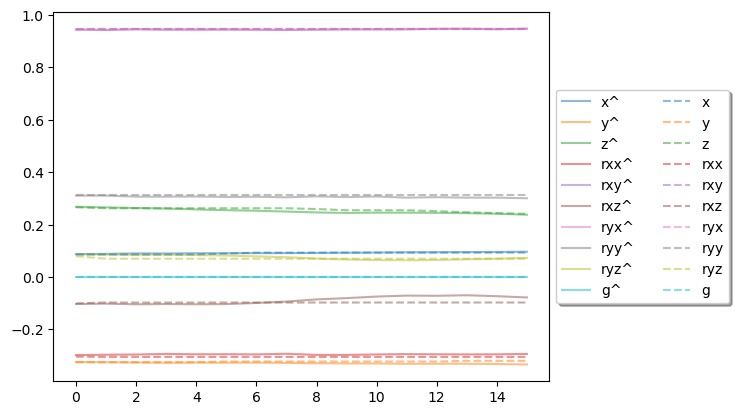

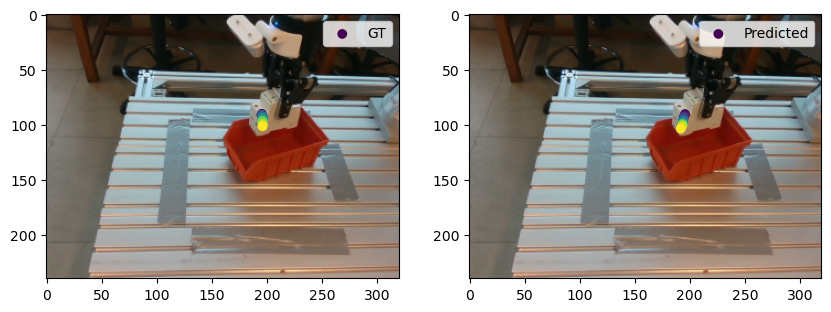

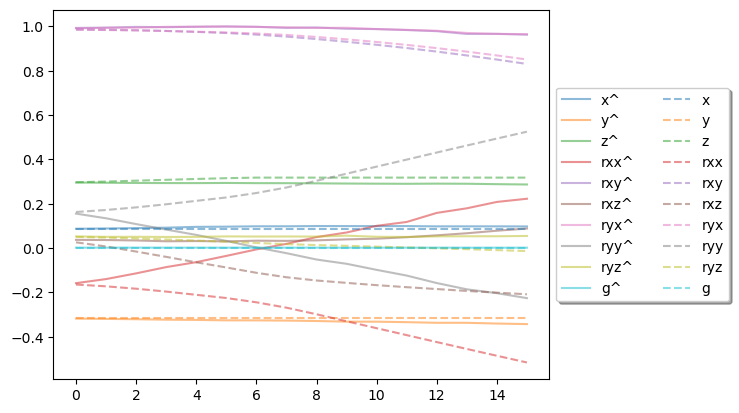

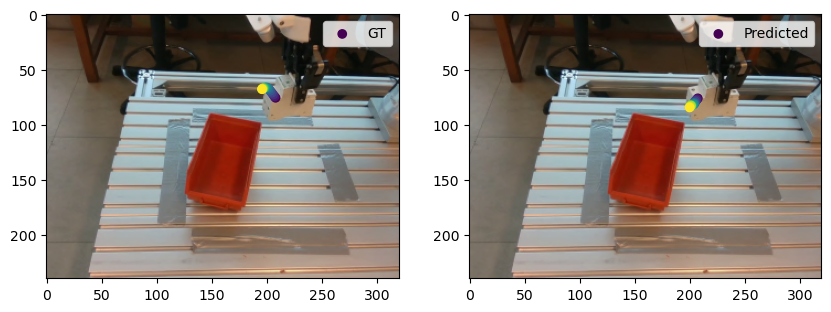

True

In [12]:
# sample 20 random samples and visualize
import random
imgs = []
for i in range(2):
    idx = random.randint(0, len(dataset))
    obs = dataset[idx]
    img = visualize_inference(obs, policy)
    imgs.append(img)

# store as one big image
import cv2
img = cv2.vconcat(imgs)
# convert to bgr
img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGRA)
cv2.imwrite("inference_results.png", img)

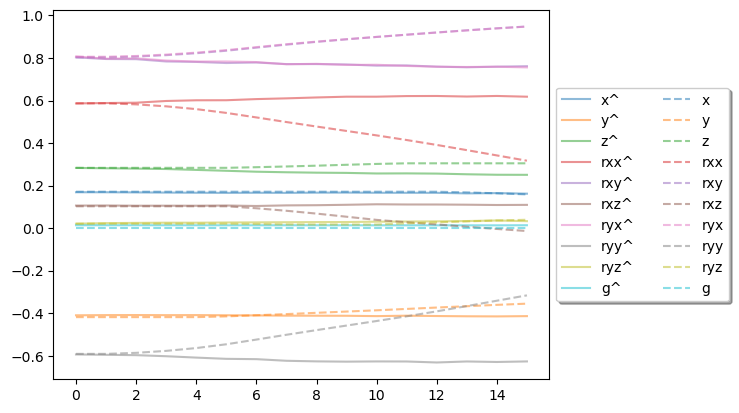

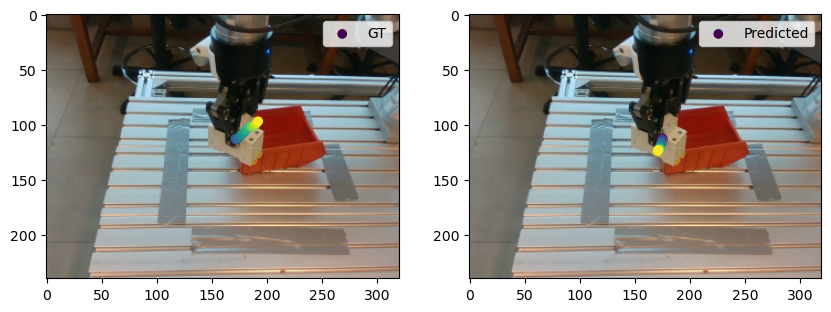

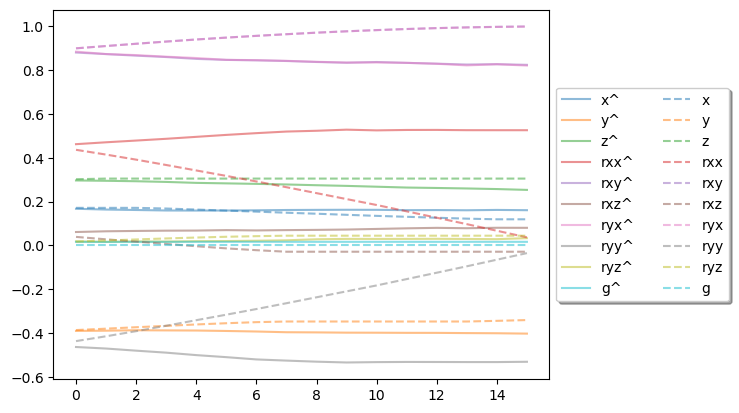

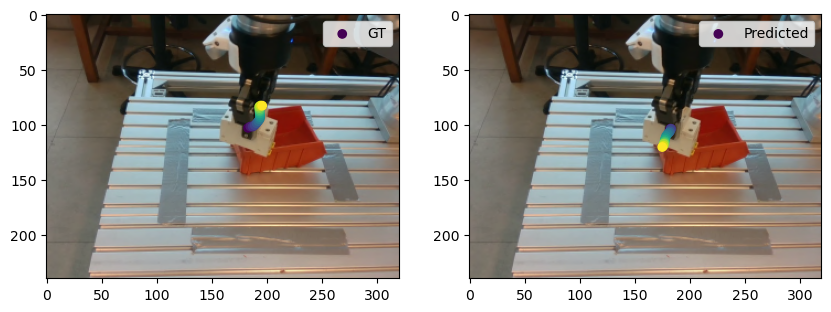

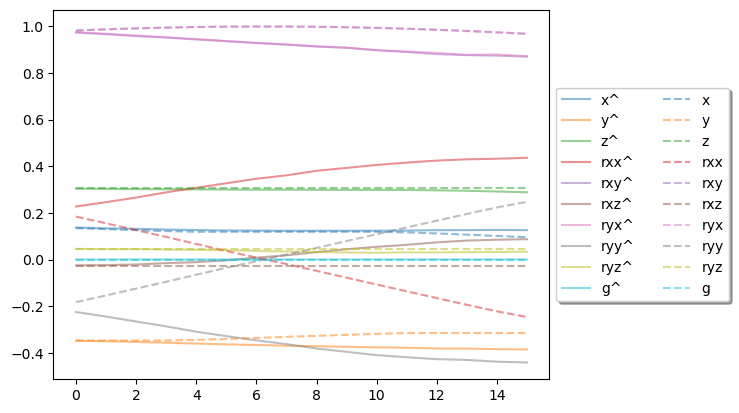

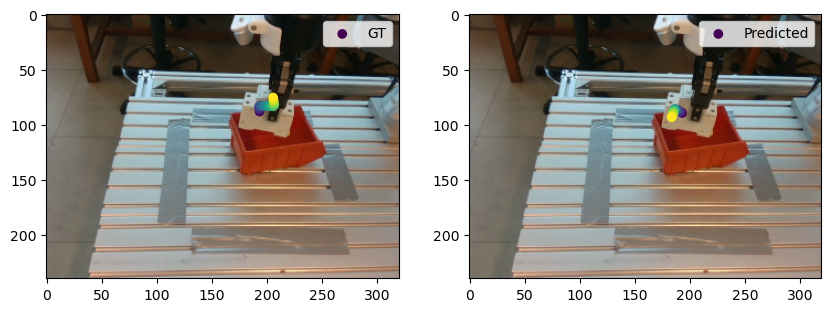

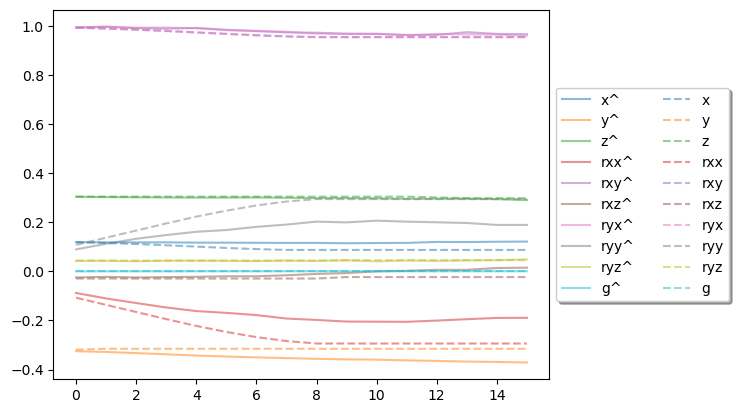

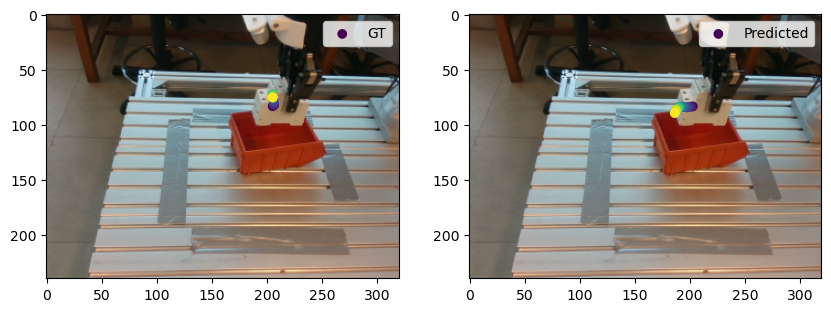

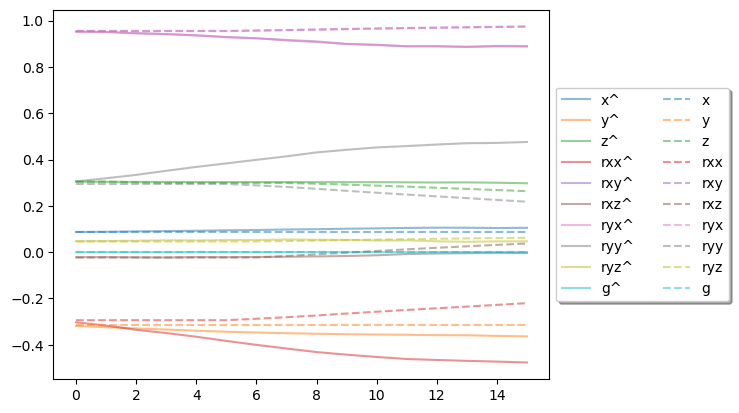

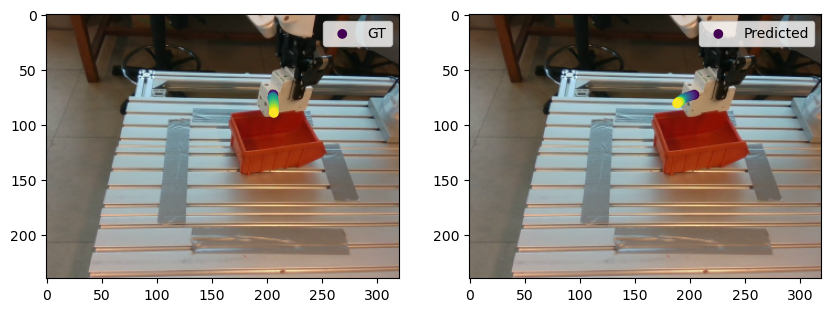

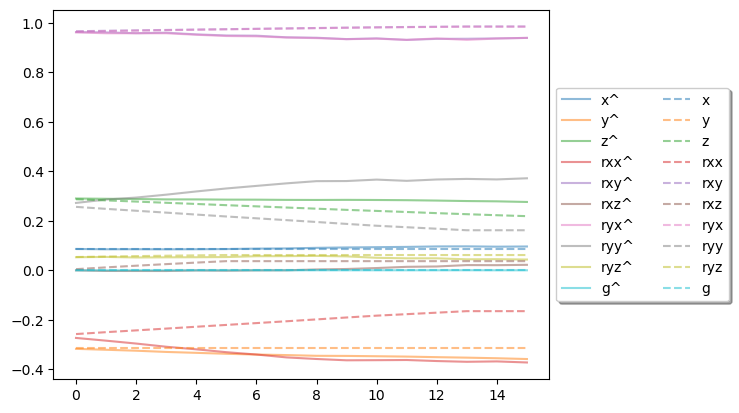

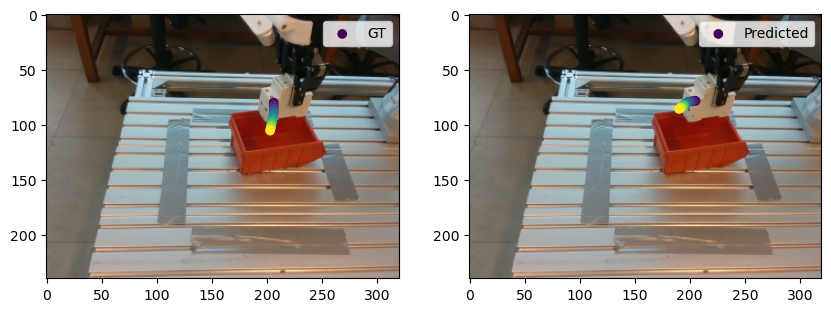

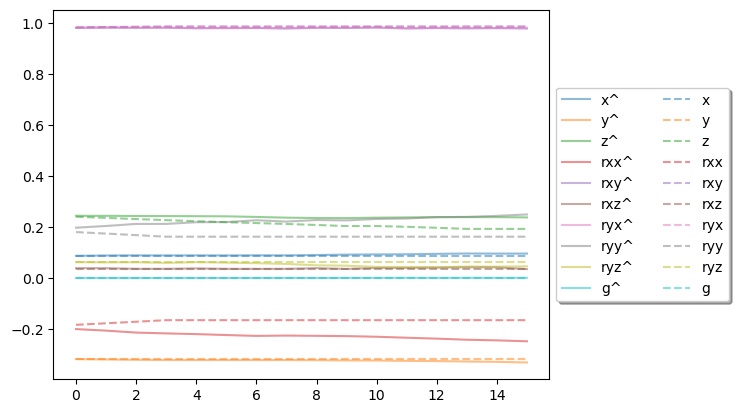

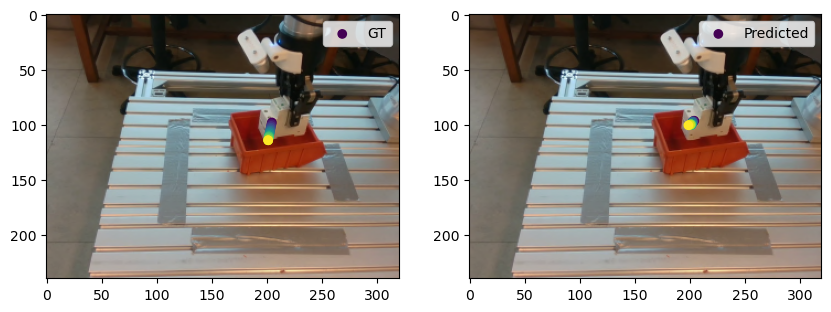

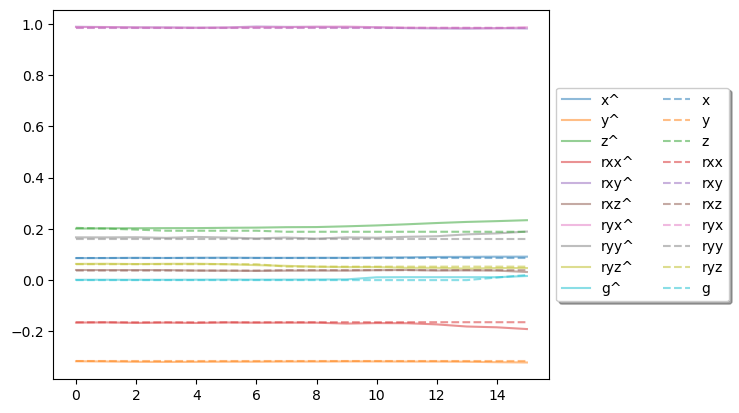

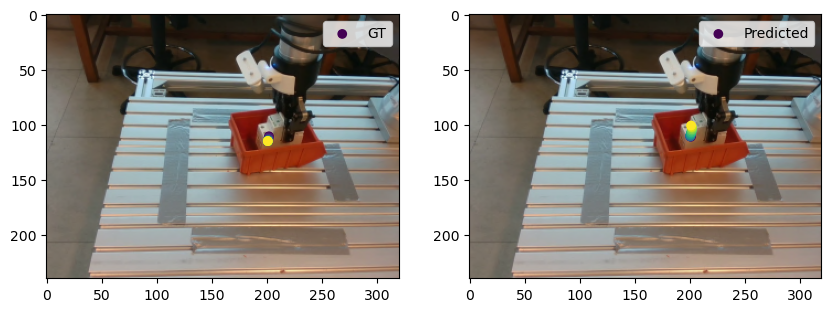

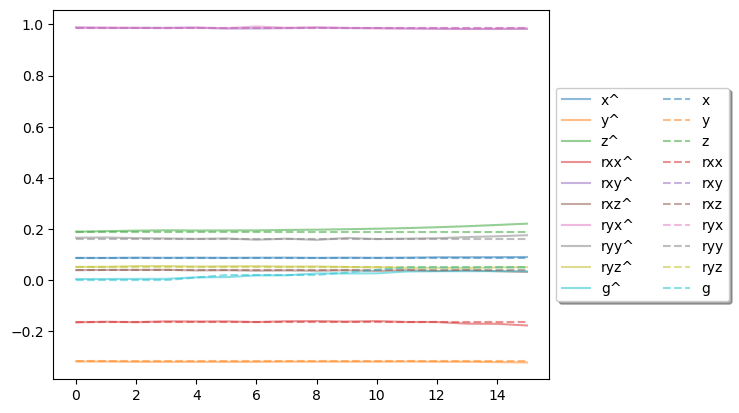

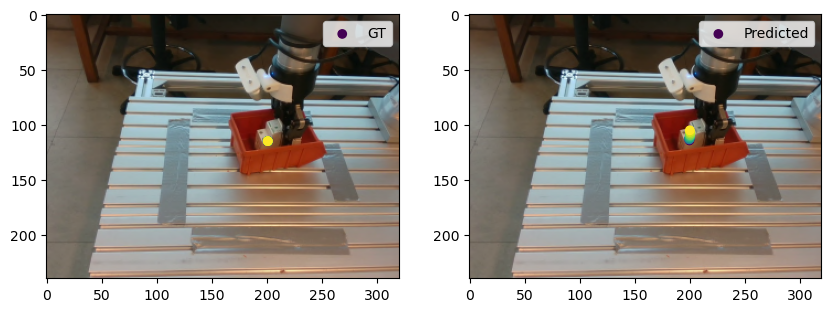

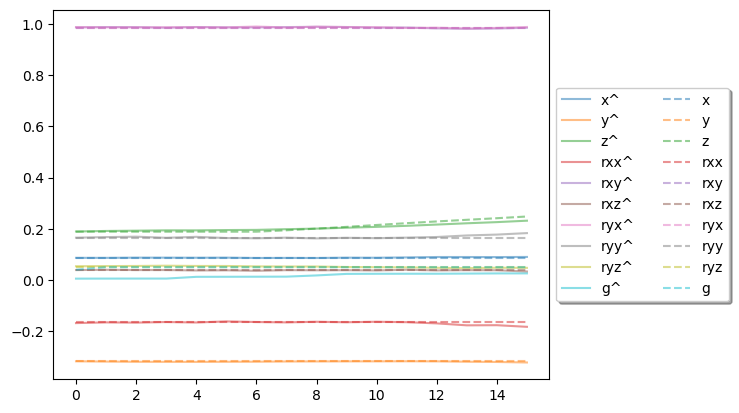

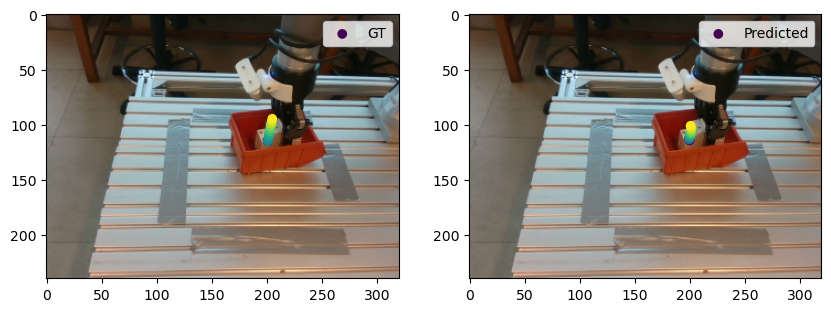

In [13]:
idx = 0

for i in range(idx,idx+100,10):
    obs = dataset[i]
    img = visualize_inference(obs, policy)
